In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix

from lazypredict.Supervised import LazyClassifier

heart = pd.read_csv("heart_disease_df_1.csv")
heart.sample(15, random_state=43)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
837,52,1,2.00,172,199.00,1,1.00,162,0,NaN,2,0,3,1
143,34,1,3.00,118,182.00,0,0.00,174,0,NaN,2,0,2,1
27,58,0,1.00,136,319.00,1,0.00,152,0,NaN,2,2,2,0
363,53,1,2.00,130,246.00,1,0.00,173,0,NaN,2,3,2,1
870,48,0,2.00,130,275.00,0,1.00,139,0,NaN,2,0,2,1
851,37,1,NaN,130,250.00,0,1.00,187,0,NaN,0,0,2,1
128,52,1,2.00,138,223.00,0,1.00,169,0,NaN,2,4,2,1
869,56,1,1.00,120,236.00,0,1.00,178,0,NaN,2,0,2,1
782,64,0,0.00,130,303.00,0,1.00,122,0,NaN,1,2,2,1
1000,64,1,0.00,145,212.00,0,0.00,132,0,NaN,1,2,1,0


In [3]:
# information on the value counts and datatypes for the dataset
heart.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1076 non-null   int64  
 1   sex       1076 non-null   int64  
 2   cp        1023 non-null   float64
 3   trestbps  1076 non-null   int64  
 4   chol      1021 non-null   float64
 5   fbs       1076 non-null   int64  
 6   restecg   1028 non-null   float64
 7   thalach   1076 non-null   int64  
 8   exang     1076 non-null   int64  
 9   oldpeak   0 non-null      float64
 10  slope     1076 non-null   int64  
 11  ca        1076 non-null   int64  
 12  thal      1076 non-null   int64  
 13  target    1076 non-null   int64  
dtypes: float64(4), int64(10)
memory usage: 117.8 KB


In [4]:
# detailed description of the data
heart.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1076.00,1076.00,1023.00,1076.00,1021.00,1076.00,1028.00,1076.00,1076.00,0.00,1076.00,1076.00,1076.00,1076.00
mean,54.55,0.69,0.95,131.75,245.54,0.15,0.53,149.15,0.33,NaN,1.39,0.76,2.33,0.51
std,9.00,0.46,1.02,17.47,50.35,0.36,0.53,22.81,0.47,NaN,0.62,1.03,0.62,0.50
min,29.00,0.00,0.00,94.00,126.00,0.00,0.00,71.00,0.00,NaN,0.00,0.00,0.00,0.00
25%,48.00,0.00,0.00,120.00,211.00,0.00,0.00,133.00,0.00,NaN,1.00,0.00,2.00,0.00
50%,56.00,1.00,1.00,130.00,240.00,0.00,1.00,152.00,0.00,NaN,1.00,0.00,2.00,1.00
75%,61.00,1.00,2.00,140.00,275.00,0.00,1.00,166.00,1.00,NaN,2.00,1.00,3.00,1.00
max,77.00,1.00,3.00,200.00,564.00,1.00,2.00,202.00,1.00,NaN,2.00,4.00,3.00,1.00


In [5]:
heart_clean = heart.drop(columns='oldpeak').ffill()
heart_clean

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,ca,thal,target
0,52,1,0.00,125,212.00,0,1.00,168,0,2,2,3,0
1,53,1,0.00,140,203.00,1,0.00,155,1,0,0,3,0
2,70,1,0.00,145,174.00,0,1.00,125,1,0,0,3,0
3,61,1,0.00,148,203.00,0,1.00,161,0,2,1,3,0
4,62,0,0.00,138,294.00,1,1.00,106,0,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,51,0,2.00,130,256.00,0,0.00,149,0,2,0,2,1
1072,54,0,2.00,160,201.00,0,1.00,163,0,2,1,2,1
1073,59,1,2.00,126,218.00,1,1.00,134,0,1,1,1,0
1074,58,0,1.00,136,319.00,1,0.00,152,0,2,2,2,0


In [6]:
# making dure that there are no missing values
heart_clean.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
slope       0
ca          0
thal        0
target      0
dtype: int64

### EXPLORATORY DATA ANALYSIS

In [7]:
# spliting the data frame between men and women 
men = heart_clean.set_index('sex').loc[1]
women = heart_clean.set_index('sex').loc[0]
men.sort_values('age')
#women = heart_clean.set_index('sex').loc[0]

,age,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,ca,thal,target
sex,,,,,,,,,,,,
1,29,1.00,130,204.00,0,0.00,202,0,2,0,2,1
1,29,1.00,130,204.00,0,0.00,202,0,2,0,2,1
1,29,1.00,130,204.00,0,0.00,202,0,2,0,2,1
1,29,0.00,130,204.00,0,0.00,202,0,2,0,2,1
1,34,3.00,118,182.00,0,0.00,174,0,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1,70,0.00,145,174.00,0,1.00,125,1,0,0,3,0
1,70,0.00,130,322.00,0,0.00,109,0,1,3,2,0
1,77,0.00,125,304.00,0,0.00,162,1,2,3,2,0


In [8]:
# grouping the dataset by age and sex and getting the mean of the coressponding features
heart_stats = heart_clean.groupby(['sex', 'age'])[heart_clean.drop(['sex', 'age', 'target'], axis=1).columns].mean()
heart_stats

cp  trestbps   chol  fbs  restecg  thalach  exang  slope   ca  thal
sex age                                                                      
0   34  1.00    118.00 210.00 0.00     1.00   192.00   0.00   2.00 0.00  2.00
    35  0.00    138.00 183.00 0.00     1.00   182.00   0.00   2.00 0.00  2.00
    37  2.00    120.00 215.00 0.00     1.00   170.00   0.00   2.00 0.00  2.00
    39  2.00    119.14 211.00 0.00     1.00   163.57   0.00   1.43 0.00  2.00
    41  1.31    118.85 247.38 0.00     0.54   168.31   0.23   2.00 0.23  2.00
...      ...       ...    ...  ...      ...      ...    ...    ...  ...   ...
1   67  0.30    130.57 249.74 0.13     0.26   122.83   0.52   1.00 1.48  2.52
    68  1.40    144.40 250.90 0.60     0.70   147.70   0.30   1.40 1.00  3.00
    69  2.38    147.50 246.50 0.38     0.00   140.38   0.00   1.00 2.25  2.62
    70  0.64    146.29 251.86 0.00     0.50   121.50   0.50   0.93 1.07  2.50
    77  0.00    125.00 304.00 0.00     0.00   162.00   1.00   2.00 3.00  2.00

[73 rows x 10 columns]

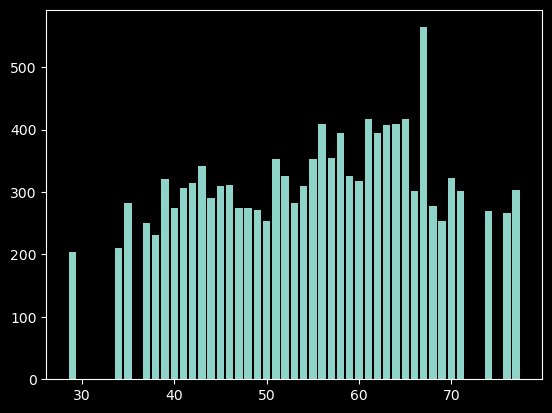

In [41]:
plt.bar(heart_clean['age'].values, heart_clean['chol'].values, )
plt.show()

### MODEL TRAINING

In [10]:
# using lazy regressor to chose the appropriate model
x = heart_clean.drop('target', axis=1)
y = heart_clean['target']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=34, train_size=.7)

lazy = LazyClassifier(verbose=1, ignore_warnings=True, random_state=43)
models, predictions = lazy.fit(xtrain, xtest, ytrain, ytest)
predictions.sort_values('Time Taken')

 10%|█         | 3/29 [00:00<00:03,  7.12it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.891640866873065, 'Balanced Accuracy': 0.8918389303004688, 'ROC AUC': 0.8918389303004688, 'F1 Score': 0.8916783091996242, 'Time taken': 0.37675023078918457}
{'Model': 'BaggingClassifier', 'Accuracy': 0.9690402476780186, 'Balanced Accuracy': 0.970414201183432, 'ROC AUC': 0.970414201183432, 'F1 Score': 0.9690550887926076, 'Time taken': 0.0858006477355957}
{'Model': 'BernoulliNB', 'Accuracy': 0.8575851393188855, 'Balanced Accuracy': 0.8564128179512795, 'ROC AUC': 0.8564128179512794, 'F1 Score': 0.8574124122238811, 'Time taken': 0.027281761169433594}


 17%|█▋        | 5/29 [00:00<00:03,  7.63it/s]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.8544891640866873, 'Balanced Accuracy': 0.8534542380696227, 'ROC AUC': 0.8534542380696228, 'F1 Score': 0.8543491542377394, 'Time taken': 0.21919727325439453}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.9690402476780186, 'Balanced Accuracy': 0.970414201183432, 'ROC AUC': 0.970414201183432, 'F1 Score': 0.9690550887926076, 'Time taken': 0.0321812629699707}
{'Model': 'DummyClassifier', 'Accuracy': 0.5232198142414861, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.35944775856427297, 'Time taken': 0.020862579345703125}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.9907120743034056, 'Balanced Accuracy': 0.9905479136248367, 'ROC AUC': 0.9905479136248366, 'F1 Score': 0.9907106463940425, 'Time taken': 0.020810365676879883}


 38%|███▊      | 11/29 [00:01<00:01, 11.33it/s]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.9969040247678018, 'Balanced Accuracy': 0.9970414201183432, 'ROC AUC': 0.9970414201183432, 'F1 Score': 0.9969044410013997, 'Time taken': 0.204789400100708}
{'Model': 'GaussianNB', 'Accuracy': 0.8018575851393189, 'Balanced Accuracy': 0.8017175132559748, 'ROC AUC': 0.8017175132559748, 'F1 Score': 0.801907044651477, 'Time taken': 0.024233579635620117}
{'Model': 'KNeighborsClassifier', 'Accuracy': 0.8328173374613003, 'Balanced Accuracy': 0.8321678321678322, 'ROC AUC': 0.8321678321678321, 'F1 Score': 0.8327627026042616, 'Time taken': 0.12088775634765625}


 45%|████▍     | 13/29 [00:01<00:01, 10.05it/s]

{'Model': 'LabelPropagation', 'Accuracy': 0.9938080495356038, 'Balanced Accuracy': 0.9940828402366864, 'ROC AUC': 0.9940828402366864, 'F1 Score': 0.9938095951453586, 'Time taken': 0.10991597175598145}
{'Model': 'LabelSpreading', 'Accuracy': 0.9938080495356038, 'Balanced Accuracy': 0.9940828402366864, 'ROC AUC': 0.9940828402366864, 'F1 Score': 0.9938095951453586, 'Time taken': 0.13972997665405273}


 52%|█████▏    | 15/29 [00:01<00:01,  9.47it/s]

{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.8513931888544891, 'Balanced Accuracy': 0.8487666179973872, 'ROC AUC': 0.8487666179973872, 'F1 Score': 0.8506801153856383, 'Time taken': 0.0985560417175293}
{'Model': 'LinearSVC', 'Accuracy': 0.8606811145510835, 'Balanced Accuracy': 0.8593713978329363, 'ROC AUC': 0.8593713978329364, 'F1 Score': 0.8604745075082878, 'Time taken': 0.13864541053771973}
{'Model': 'LogisticRegression', 'Accuracy': 0.8544891640866873, 'Balanced Accuracy': 0.8534542380696227, 'ROC AUC': 0.8534542380696228, 'F1 Score': 0.8543491542377394, 'Time taken': 0.02980804443359375}
{'Model': 'NearestCentroid', 'Accuracy': 0.8111455108359134, 'Balanced Accuracy': 0.809152386075463, 'ROC AUC': 0.809152386075463, 'F1 Score': 0.8106244223589668, 'Time taken': 0.025937557220458984}


 72%|███████▏  | 21/29 [00:01<00:00, 13.60it/s]

{'Model': 'NuSVC', 'Accuracy': 0.8792569659442725, 'Balanced Accuracy': 0.8797164374087452, 'ROC AUC': 0.8797164374087451, 'F1 Score': 0.8793148879400968, 'Time taken': 0.06324434280395508}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.7801857585139319, 'Balanced Accuracy': 0.7784138937985092, 'ROC AUC': 0.7784138937985091, 'F1 Score': 0.779728134385849, 'Time taken': 0.05358004570007324}
{'Model': 'Perceptron', 'Accuracy': 0.7461300309597523, 'Balanced Accuracy': 0.7447168216398985, 'ROC AUC': 0.7447168216398985, 'F1 Score': 0.7458221261382227, 'Time taken': 0.04257941246032715}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.8328173374613003, 'Balanced Accuracy': 0.8310151387074465, 'ROC AUC': 0.8310151387074464, 'F1 Score': 0.8324143089799045, 'Time taken': 0.08825182914733887}


 86%|████████▌ | 25/29 [00:02<00:00, 10.16it/s]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.978328173374613, 'Balanced Accuracy': 0.9792899408284024, 'ROC AUC': 0.9792899408284024, 'F1 Score': 0.9783398131606488, 'Time taken': 0.36865973472595215}
{'Model': 'RidgeClassifier', 'Accuracy': 0.8513931888544891, 'Balanced Accuracy': 0.8487666179973872, 'ROC AUC': 0.8487666179973872, 'F1 Score': 0.8506801153856383, 'Time taken': 0.057961225509643555}
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.8544891640866873, 'Balanced Accuracy': 0.8525897179743334, 'ROC AUC': 0.8525897179743332, 'F1 Score': 0.8540876696864171, 'Time taken': 0.0531919002532959}
{'Model': 'SGDClassifier', 'Accuracy': 0.8328173374613003, 'Balanced Accuracy': 0.8350495658187966, 'ROC AUC': 0.8350495658187965, 'F1 Score': 0.8327307973560751, 'Time taken': 0.08238768577575684}
{'Model': 'SVC', 'Accuracy': 0.9318885448916409, 'Balanced Accuracy': 0.9320295089525859, 'ROC AUC': 0.9320295089525859, 'F1 Score': 0.9319055465989451, 'Time taken': 0.05980563163757324}


 97%|█████████▋| 28/29 [00:02<00:00,  8.67it/s]

{'Model': 'XGBClassifier', 'Accuracy': 0.9907120743034056, 'Balanced Accuracy': 0.9911242603550297, 'ROC AUC': 0.9911242603550297, 'F1 Score': 0.9907152836456821, 'Time taken': 0.3724937438964844}
[LightGBM] [Info] Number of positive: 382, number of negative: 371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507304 -> initscore=0.029219
[LightGBM] [Info] Start training from score 0.029219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

100%|██████████| 29/29 [00:03<00:00,  8.68it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
{'Model': 'LGBMClassifier', 'Accuracy': 0.9876160990712074, 'Balanced Accuracy': 0.9878775071082764, 'ROC AUC': 0.9878775071082765, 'F1 Score': 0.9876191902907173, 'Time taken': 0.37829065322875977}


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreeClassifier,0.99,0.99,0.99,0.99,0.02
DummyClassifier,0.52,0.50,0.50,0.36,0.02
GaussianNB,0.80,0.80,0.80,0.80,0.02
NearestCentroid,0.81,0.81,0.81,0.81,0.03
BernoulliNB,0.86,0.86,0.86,0.86,0.03
LogisticRegression,0.85,0.85,0.85,0.85,0.03
DecisionTreeClassifier,0.97,0.97,0.97,0.97,0.03
Perceptron,0.75,0.74,0.74,0.75,0.04
RidgeClassifierCV,0.85,0.85,0.85,0.85,0.05


In [15]:
params = {
    "criterion": ['gini', 'entropy', 'log_loss'],
    "max_depth": [1, 5 , 10],
    # "random_state": 5
}

extra = ExtraTreeClassifier()
dtc = DecisionTreeClassifier()

# employing randsearchcv to find the best model configureations amongst the models
models = [dtc, extra]

kfold = KFold(n_splits=5, shuffle=True, random_state=41)

for model in models:
    rand = RandomizedSearchCV(estimator=model,
                              param_distributions=params, 
                              n_iter=5, 
                              cv=kfold,
                              random_state=456)
    rand.fit(xtrain, ytrain)
    print(rand.best_estimator_, rand.best_score_)
# hyperparameter tunning 

models = [dtc, extra]
for model in models:
    scores = cross_val_score(model, xtrain, ytrain, cv=kfold,)
    print(scores)

DecisionTreeClassifier(criterion='log_loss', max_depth=10) 0.9667814569536424
ExtraTreeClassifier(criterion='log_loss', max_depth=10) 0.8858278145695365
[0.93377483 0.95364238 0.98013245 0.97333333 0.88666667]
[0.94701987 0.91390728 0.94701987 0.96666667 0.94      ]


In [42]:
rf = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=5)

params = {
    "n_estimators": [100, 200, 300],
    "criterion": ['entropy', 'gini', 'log_loss'],
    "max_depth": [4, 5, 6]
}


random_ens = RandomizedSearchCV(
        estimator=rf,
        n_iter=10,
        param_distributions=params
)
random_ens.fit(xtrain, ytrain)
print(random_ens.best_params_, random_ens.best_score_)

{'n_estimators': 200, 'max_depth': 6, 'criterion': 'entropy'} 0.9375805739514348


In [22]:
dt = DecisionTreeClassifier(criterion='log_loss', max_depth=10)
dt.fit(xtrain, ytrain)
ypred = dt.predict(xtest)
print(confusion_matrix(ytest, ypred))

[[151   3]
 [  7 162]]
